# Table of Contents
1. [Step 1: Gather the Data](#step1)
1. [Step 2: Prepare Data for Consumption](#step2)
   - [2.1 Import Libraries](#step2.1)
   - [2.1 Meet The Data](#step2.2)
   - [2.3 Clean Data](#step2.3)
   - [2.4 Convert Formats](#step2.4)
1. [Step 3: Visualization](#step3)

<a id="step1"></a>
# Step 1: Gather the Data
The data collected and created at create_ds.ipynb script

<a id="step2"></a>
# Step 2: Prepare Data for Consumption

<a id="step2.1"></a>
## 2.1 Import Libraries

In [1]:
import sys
print("Python version: {}". format(sys.version))

import datetime

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
print("SciPy version: {}". format(sp.__version__)) 

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
print("ipywidgets version: {}". format(widgets.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))
%matplotlib inline

pd.set_option('display.max_columns', None)
sns.set(style='white', context='notebook', palette='deep')

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Python version: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 19:29:22) [MSC v.1916 32 bit (Intel)]
pandas version: 1.0.3
NumPy version: 1.18.2
SciPy version: 1.4.1
matplotlib version: 3.2.1
ipywidgets version: 7.5.1
seaborn version: 0.10.0


<a id="step2.2"></a>
## 2.2 Meet The Data

In [2]:
def print_info(df):
    df.info()
    print("\nshape: " + str(df.shape) + "\n")
    print(df.isna().sum())

Data explanation should be here

In [3]:
df = pd.read_csv("./input/autotel_with_target.csv",dtype={
    "Order number": "str",
    "Year": "str",
    "Month": "str",
    "Day": "str",
    "Hour": "str",
    "Minute": "str",
} ,index_col=0)

c:\projects\python\ssd\venv\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# print(df.isnull().sum())
# df.describe(include='all')

<a id="step2.3"><a/>
## 2.3 Clean Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136155 entries, 0 to 136154
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Car id                    136155 non-null  object 
 1   Order number              136155 non-null  object 
 2   Category                  136155 non-null  object 
 3   Avg distance              136155 non-null  int64  
 4   Billing minutes           132902 non-null  object 
 5   Address                   136155 non-null  object 
 6   Time                      134980 non-null  object 
 7   kmh                       132860 non-null  float64
 8   Coords                    134957 non-null  object 
 9   Lat                       134957 non-null  float64
 10  Lon                       134957 non-null  float64
 11  neighborhood              134957 non-null  object 
 12  Area                      134957 non-null  float64
 13  Population                134957 non-null  f

### 2.3. Filling empy billing minutes with 0, most of the time its canceled drive

In [6]:
df['Billing minutes'] = pd.to_numeric(df['Billing minutes'],errors='coerce')
df['Billing minutes'] = df['Billing minutes'].fillna(0)

### 2.3. Delete empty adresses

In [7]:
delete_empty_addresses = df["Address"].isnull()

In [8]:
df = df[~delete_empty_addresses]
# This is works too
# df.drop(delete_empty_addresses.index,inplace=True)
# df = df[pd.notnull(df['Address'])]

In [9]:
df["Address"].isnull().sum()

0

### 2.3. Fill na Street_c by Street
the na is only from streets consists only from numbers

In [10]:
df['Street_c'].fillna(df['Street'], inplace = True)

### 2.3. Delete canceled and NO SHOW category rows

In [11]:
df = df[(df['Category'] != 'Canceled') & (df['Category'] != 'NO SHOW')]

### 2.3. Delete empty kmh drives
Those rows with same start and destination addresses and the drive did not happen

In [12]:
df = df[(df['Avg distance'] != 0) & (df['Billing minutes'] != 0)]

### 2.3. Filling na kmh
formula = Avg distance/(Billing minutes/60)

In [13]:
# df['kmh'] = df.apply(lambda row : row['Avg distance']*(row['Billing minutes']/60) if np.isnan(row['kmh']) else row['kmh'],axis=1)

In [14]:
df['kmh'].fillna(df['Avg distance']*(df['Billing minutes']/60),inplace=True)

### 2.3. Filling empty Lat Lon Coords by similar Address rows

In [15]:
AddressCols = ['Address','Lat','Lon','neighborhood','Coords']
df[AddressCols] = df[AddressCols].sort_values(['Address']).ffill()

### 2.3. Filling na weather data with previous data

In [16]:
weatherCols = ['Time','Temprature','Max Temprature','Min Temprature','Relative Humidity','Amount of Rain','Wind Speed','Wind Direction','Max Wind Speed per Min','Max Win Speed per 10 Min']
df[weatherCols] = df[weatherCols].sort_values(['Time']).ffill()

### 2.3. Filling na Area and Population
Filling by same neighborhoods

In [17]:
neighborhoodMetaCols = ["neighborhood","Area","Population"]
df[neighborhoodMetaCols] = df[neighborhoodMetaCols].sort_values(['neighborhood']).ffill()

### 2.3. Delete empty target rows

In [18]:
df.dropna(subset=['count'],inplace=True)

### 2.3. Delete unneeded columns

In [19]:
df.drop(["Category","Car id","Order number","Address","Time","Street","City","Country","Address_c","Address_c2","Street_c","Coords","Lat","Lon","Avg distance","Billing minutes","kmh","Minute","Max Wind Speed per Min","Max Win Speed per 10 Min","Max Temprature","Min Temprature"],axis=1,inplace=True)
# After visualization delete Coords, Date

In [20]:
to_numeric = ['Year', 'Month', 'Day', 'Hour']
df[to_numeric] = df[to_numeric].apply(pd.to_numeric)
df['Date'] = pd.to_datetime(df['Date'])
df['day_name'] = df['Date'].dt.dayofweek

# Make the data grouped by Neighborhood, Date and Hour

In [21]:
df = df.groupby(['neighborhood','Date','Hour']).agg({
    'Area': 'first',
    'Population': 'first',
    'Year': 'first',
    'Month': 'first',
    'Day': 'first',
    'day_name': 'first',
    'Temprature': 'mean',
#     'Max Temprature': 'max',
#     'Min Temprature': 'min',
    'Relative Humidity': 'mean',
    'Amount of Rain': 'mean',
    'Wind Speed': 'mean',
    'Wind Direction': 'mean',
    'count': 'first'
}).reset_index()

In [22]:
# df.to_csv("./input/autotel_with_target_groupedby.csv", encoding='utf-8-sig')

In [23]:
df.head()

,neighborhood,Date,Hour,Area,Population,Year,Month,Day,day_name,Temprature,Relative Humidity,Amount of Rain,Wind Speed,Wind Direction,count
0,'נאות אפקה א,2017-10-23,9.0,353611.36,3035.0,2017.0,10.0,23.0,0,25.25,53.33,0.0,1.72,276.17,5.0
1,'נאות אפקה א,2017-10-23,12.0,353611.36,3035.0,2017.0,10.0,23.0,0,25.65,58.67,0.0,4.25,302.17,27.0
2,'נאות אפקה א,2017-10-23,22.0,353611.36,3035.0,2017.0,10.0,23.0,0,22.92,62.33,0.0,1.37,127.17,12.0
3,'נאות אפקה א,2017-10-24,7.0,353611.36,3035.0,2017.0,10.0,24.0,1,20.83,69.50,0.0,2.58,119.67,1.0
4,'נאות אפקה א,2017-10-24,15.0,353611.36,3035.0,2017.0,10.0,24.0,1,25.03,58.17,0.0,4.07,294.17,4.0


## Encoding cyclical continuous features

In [24]:
df['hour_sin_time'] = np.sin(2*np.pi*df['Hour']/24)
df['hour_cos_time'] = np.cos(2*np.pi*df['Hour']/24)
df['month_sin_time'] = np.sin(2*np.pi*df['Month']/12)
df['month_cos_time'] = np.cos(2*np.pi*df['Month']/12)
df['day_sin_time'] = np.sin(2*np.pi*df['Day']/31)
df['day_cos_time'] = np.cos(2*np.pi*df['Day']/31)

In [25]:
df[['Hour','Year','Month','Day']] = df[['Hour','Year','Month','Day']].astype(str)

In [26]:
count = df['count']
df.drop(labels=['count'], axis=1,inplace = True)
df['count'] = count

In [27]:
print_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51076 entries, 0 to 51075
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   neighborhood       51076 non-null  object        
 1   Date               51076 non-null  datetime64[ns]
 2   Hour               51076 non-null  object        
 3   Area               51076 non-null  float64       
 4   Population         51076 non-null  float64       
 5   Year               51076 non-null  object        
 6   Month              51076 non-null  object        
 7   Day                51076 non-null  object        
 8   day_name           51076 non-null  int64         
 9   Temprature         51076 non-null  float64       
 10  Relative Humidity  51076 non-null  float64       
 11  Amount of Rain     51076 non-null  float64       
 12  Wind Speed         51076 non-null  float64       
 13  Wind Direction     51076 non-null  float64       
 14  hour_s

<a id="step3"></a>
# Step 3: Visualization

In [28]:
df.head()

,neighborhood,Date,Hour,Area,Population,Year,Month,Day,day_name,Temprature,Relative Humidity,Amount of Rain,Wind Speed,Wind Direction,hour_sin_time,hour_cos_time,month_sin_time,month_cos_time,day_sin_time,day_cos_time,count
0,'נאות אפקה א,2017-10-23,9.0,353611.36,3035.0,2017.0,10.0,23.0,0,25.25,53.33,0.0,1.72,276.17,7.071068e-01,-0.707107,-0.866025,0.5,-0.998717,-0.050649,5.0
1,'נאות אפקה א,2017-10-23,12.0,353611.36,3035.0,2017.0,10.0,23.0,0,25.65,58.67,0.0,4.25,302.17,1.224647e-16,-1.000000,-0.866025,0.5,-0.998717,-0.050649,27.0
2,'נאות אפקה א,2017-10-23,22.0,353611.36,3035.0,2017.0,10.0,23.0,0,22.92,62.33,0.0,1.37,127.17,-5.000000e-01,0.866025,-0.866025,0.5,-0.998717,-0.050649,12.0
3,'נאות אפקה א,2017-10-24,7.0,353611.36,3035.0,2017.0,10.0,24.0,1,20.83,69.50,0.0,2.58,119.67,9.659258e-01,-0.258819,-0.866025,0.5,-0.988468,0.151428,1.0
4,'נאות אפקה א,2017-10-24,15.0,353611.36,3035.0,2017.0,10.0,24.0,1,25.03,58.17,0.0,4.07,294.17,-7.071068e-01,-0.707107,-0.866025,0.5,-0.988468,0.151428,4.0


In [29]:
@interact
def show_more_then(column=list(df.select_dtypes('number').columns),x=(0,2000,5)):
    tmp = df.loc[df[column] > x].sort_values(by=column)
    return tmp

interactive(children=(Dropdown(description='column', options=('Area', 'Population', 'day_name', 'Temprature', …

In [30]:
@interact
def correlation(column1=list(df.select_dtypes('number').columns),
                column2=list(df.select_dtypes('number').columns)):
    print(f"Correlation: {df[column1].corr(df[column2])}")

interactive(children=(Dropdown(description='column1', options=('Area', 'Population', 'day_name', 'Temprature',…

### Sum of cares in all dates by neighborhoods

In [31]:
nei = df[['neighborhood','count']].groupby('neighborhood').sum().reset_index()
nei['neighborhood'] = nei.loc[:,'neighborhood'].apply(lambda x: x[::-1])
nei = nei.sort_values('count',ascending=False)
@interact
def barplot(threshold=(0,nei['count'].max(),50)):
    nei_more_then = nei[nei['count'] > threshold]
    plt.figure(figsize=(15,5))
    sns.barplot(x=nei_more_then['neighborhood'],y=nei_more_then['count'])
    plt.xticks(rotation=90)
    plt.yticks(np.arange(int(nei_more_then['count'].min()/10000)*10000, nei_more_then['count'].max(), 10000)) 
    plt.xlabel("neighborhood")
    plt.ylabel("count")

interactive(children=(FloatSlider(value=25750.0, description='threshold', max=51559.0, step=50.0), Output()), …

In [32]:
nei = df[['neighborhood','count']].groupby('neighborhood').sum().reset_index()
nei['neighborhood'] = nei.loc[:,'neighborhood'].apply(lambda x: x[::-1])
nei = nei.sort_values('count',ascending=False)
nei_more_then = nei[nei['count'] > 0]

Text(0, 0.5, 'count')

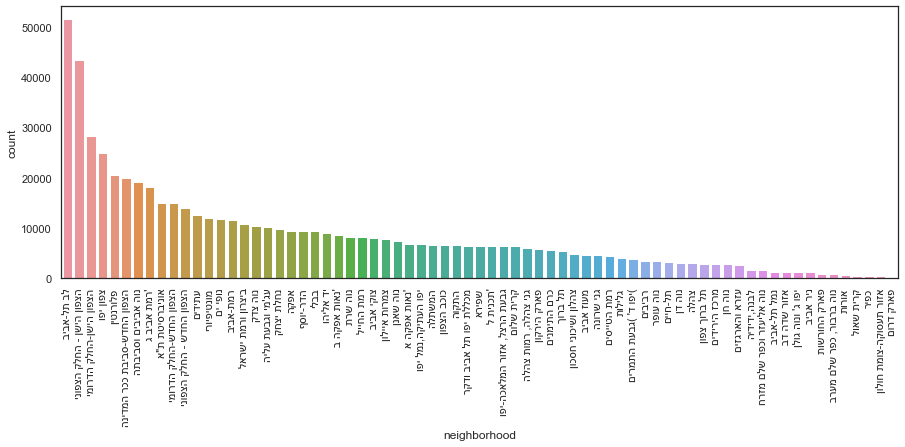

In [33]:
plt.figure(figsize=(15,5))
sns.barplot(x=nei_more_then['neighborhood'],y=nei_more_then['count'])
plt.xticks(rotation=90)
plt.yticks(np.arange(int(nei_more_then['count'].min()/1000)*1000, nei_more_then['count'].max(), 10000)) 
plt.xlabel("neighborhood")
plt.ylabel("count")

In [34]:
# nei_more_then.iplot(kind='bar',x=nei_more_then['neighborhood'],y=nei_more_then['count'])
# plt.xticks(rotation=90)
# plt.yticks(np.arange(int(nei_more_then['count'].min()/1000)*1000, nei_more_then['count'].max(), 10000)) 
# plt.xlabel("neighborhood")
# plt.ylabel("count")

### Correlation Matrix

In [35]:
print(df[['Hour', 'count']].groupby('Hour', as_index=False).mean())

    Hour      count
0    0.0  15.596740
1    1.0  13.685739
2   10.0  10.706058
3   11.0   9.002856
4   12.0   9.391583
5   13.0   9.231138
6   14.0   9.578393
7   15.0   9.943764
8   16.0  10.550204
9   17.0  10.573549
10  18.0  11.776093
11  19.0  12.365447
12   2.0  12.787795
13  20.0  13.004337
14  21.0  14.803030
15  22.0  15.997621
16  23.0  17.335235
17   3.0  10.847118
18   4.0   9.491304
19   5.0   9.100402
20   6.0   9.131387
21   7.0   8.560131
22   8.0  11.031344
23   9.0  11.756618


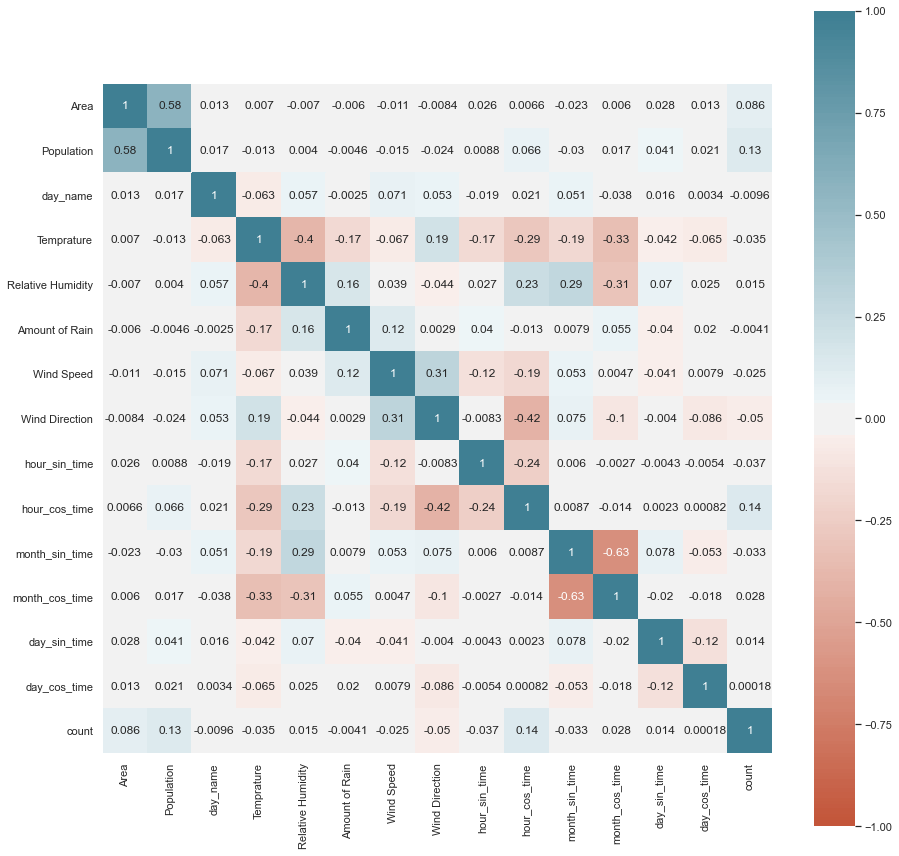

In [36]:
corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

In [37]:
df.head()

,neighborhood,Date,Hour,Area,Population,Year,Month,Day,day_name,Temprature,Relative Humidity,Amount of Rain,Wind Speed,Wind Direction,hour_sin_time,hour_cos_time,month_sin_time,month_cos_time,day_sin_time,day_cos_time,count
0,'נאות אפקה א,2017-10-23,9.0,353611.36,3035.0,2017.0,10.0,23.0,0,25.25,53.33,0.0,1.72,276.17,7.071068e-01,-0.707107,-0.866025,0.5,-0.998717,-0.050649,5.0
1,'נאות אפקה א,2017-10-23,12.0,353611.36,3035.0,2017.0,10.0,23.0,0,25.65,58.67,0.0,4.25,302.17,1.224647e-16,-1.000000,-0.866025,0.5,-0.998717,-0.050649,27.0
2,'נאות אפקה א,2017-10-23,22.0,353611.36,3035.0,2017.0,10.0,23.0,0,22.92,62.33,0.0,1.37,127.17,-5.000000e-01,0.866025,-0.866025,0.5,-0.998717,-0.050649,12.0
3,'נאות אפקה א,2017-10-24,7.0,353611.36,3035.0,2017.0,10.0,24.0,1,20.83,69.50,0.0,2.58,119.67,9.659258e-01,-0.258819,-0.866025,0.5,-0.988468,0.151428,1.0
4,'נאות אפקה א,2017-10-24,15.0,353611.36,3035.0,2017.0,10.0,24.0,1,25.03,58.17,0.0,4.07,294.17,-7.071068e-01,-0.707107,-0.866025,0.5,-0.988468,0.151428,4.0


### Number of cars in each neighborhood each year

In [38]:
t_y = df[['neighborhood','Year','count']].groupby(['neighborhood','Year']).sum().reset_index()
t_y['neighborhood'] = t_y.loc[:,'neighborhood'].apply(lambda x: x[::-1])

Text(0.5, 1.0, 'Number of cars in each neighborhood each year')

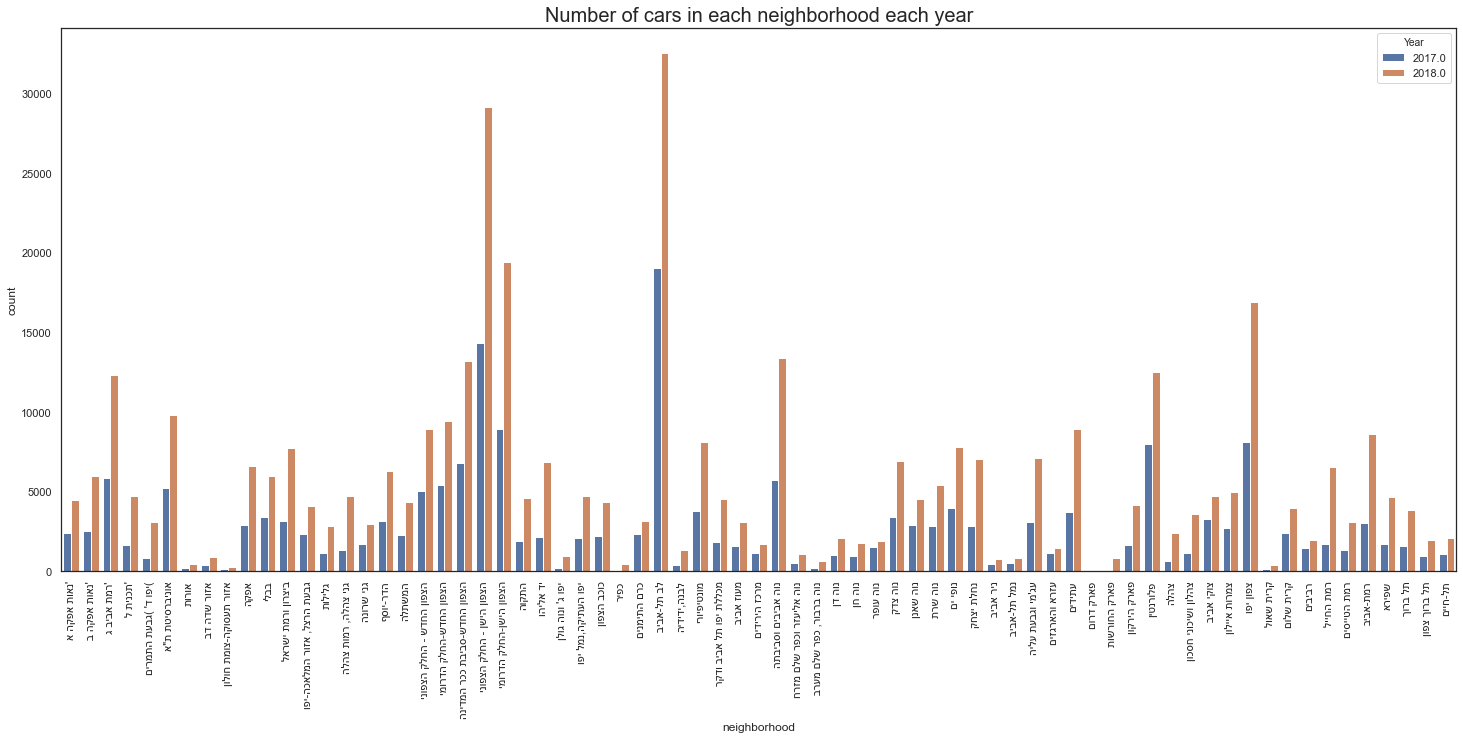

In [39]:
plt.figure(figsize=(25,10))
sns.barplot(x='neighborhood',y="count",hue='Year',data=t_y)
plt.xticks(rotation=90)
plt.title('Number of cars in each neighborhood each year',fontsize=20)

### Number of cars in each neighborhood each month above threshold

In [40]:
t_m = df[['neighborhood','Month','count']].groupby(['neighborhood','Month']).sum()
t_m_filter_max = t_m.groupby('neighborhood').max()
t_m_filter_max_more_then = t_m_filter_max[t_m_filter_max['count'] > 2000]
filtered_nei = t_m_filter_max_more_then.reset_index()['neighborhood'].unique()
rows_to_take = t_m.reset_index()['neighborhood'].isin(filtered_nei)
t_m = t_m.reset_index()[rows_to_take]
t_m['neighborhood'] = t_m.loc[:,'neighborhood'].apply(lambda x: x[::-1])
t_m['Month'] = pd.to_numeric(t_m['Month'])

Text(0.5, 1.0, 'Number of cars in each neighborhood each month above threshold')

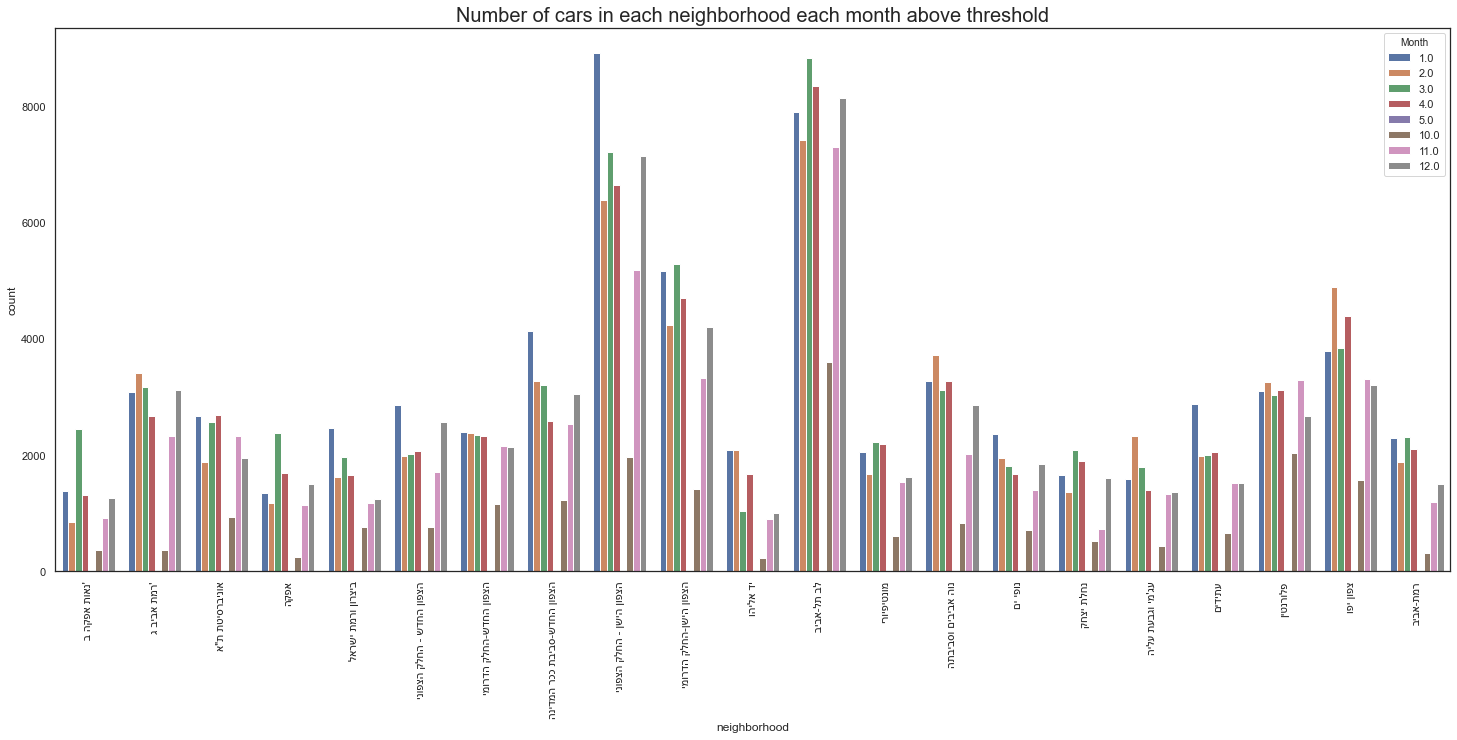

In [41]:
plt.figure(figsize=(25,10))
sns.barplot(x='neighborhood',y="count",hue='Month',data=t_m)
plt.xticks(rotation=90)
plt.title('Number of cars in each neighborhood each month above threshold',fontsize=20)

In [42]:
df.head()

,neighborhood,Date,Hour,Area,Population,Year,Month,Day,day_name,Temprature,Relative Humidity,Amount of Rain,Wind Speed,Wind Direction,hour_sin_time,hour_cos_time,month_sin_time,month_cos_time,day_sin_time,day_cos_time,count
0,'נאות אפקה א,2017-10-23,9.0,353611.36,3035.0,2017.0,10.0,23.0,0,25.25,53.33,0.0,1.72,276.17,7.071068e-01,-0.707107,-0.866025,0.5,-0.998717,-0.050649,5.0
1,'נאות אפקה א,2017-10-23,12.0,353611.36,3035.0,2017.0,10.0,23.0,0,25.65,58.67,0.0,4.25,302.17,1.224647e-16,-1.000000,-0.866025,0.5,-0.998717,-0.050649,27.0
2,'נאות אפקה א,2017-10-23,22.0,353611.36,3035.0,2017.0,10.0,23.0,0,22.92,62.33,0.0,1.37,127.17,-5.000000e-01,0.866025,-0.866025,0.5,-0.998717,-0.050649,12.0
3,'נאות אפקה א,2017-10-24,7.0,353611.36,3035.0,2017.0,10.0,24.0,1,20.83,69.50,0.0,2.58,119.67,9.659258e-01,-0.258819,-0.866025,0.5,-0.988468,0.151428,1.0
4,'נאות אפקה א,2017-10-24,15.0,353611.36,3035.0,2017.0,10.0,24.0,1,25.03,58.17,0.0,4.07,294.17,-7.071068e-01,-0.707107,-0.866025,0.5,-0.988468,0.151428,4.0


### Number of cars in each neighborhood each year, month, day, hour above threshold

In [44]:
#צריך לשים לב שלקחנו רק את הזמן שבו רכב עומד לכן אנו רואים פה בשעות הבוקר פחות רחבים כיוון שהם בתנועה

In [45]:
@interact
def barplot(column=['Year','Month','day_name','Hour'], threshold=(0,10000,50)):
    t_m = df[['neighborhood',column,'count']].groupby(['neighborhood',column]).sum()
    t_m_filter_max = t_m.groupby('neighborhood').max()
    t_m_filter_max_more_then = t_m_filter_max[t_m_filter_max['count'] > threshold]
    filtered_nei = t_m_filter_max_more_then.reset_index()['neighborhood'].unique()
    rows_to_take = t_m.reset_index()['neighborhood'].isin(filtered_nei)
    t_m = t_m.reset_index()[rows_to_take]
    t_m['neighborhood'] = t_m.loc[:,'neighborhood'].apply(lambda x: x[::-1])
    t_m[column] = pd.to_numeric(t_m[column])
    plt.figure(figsize=(25,10))
    sns.barplot(x='neighborhood',y="count",hue=column,data=t_m)
    plt.xticks(rotation=90)
    plt.title(f'Number of cars in each neighborhood each {column} above threshold',fontsize=20)

interactive(children=(Dropdown(description='column', options=('Year', 'Month', 'day_name', 'Hour'), value='Yea…